In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import cv2
import os

In [2]:
data_dir = "C:/Users/DELL/Pictures/input"
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/validation")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')

['images', 'train', 'validation']
Train Classes - ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Validation Classes - ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [3]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

df_train=ImageFolder(data_dir + "/train",transform=ToTensor())
df_valid=ImageFolder(data_dir + "/validation",transform=ToTensor())

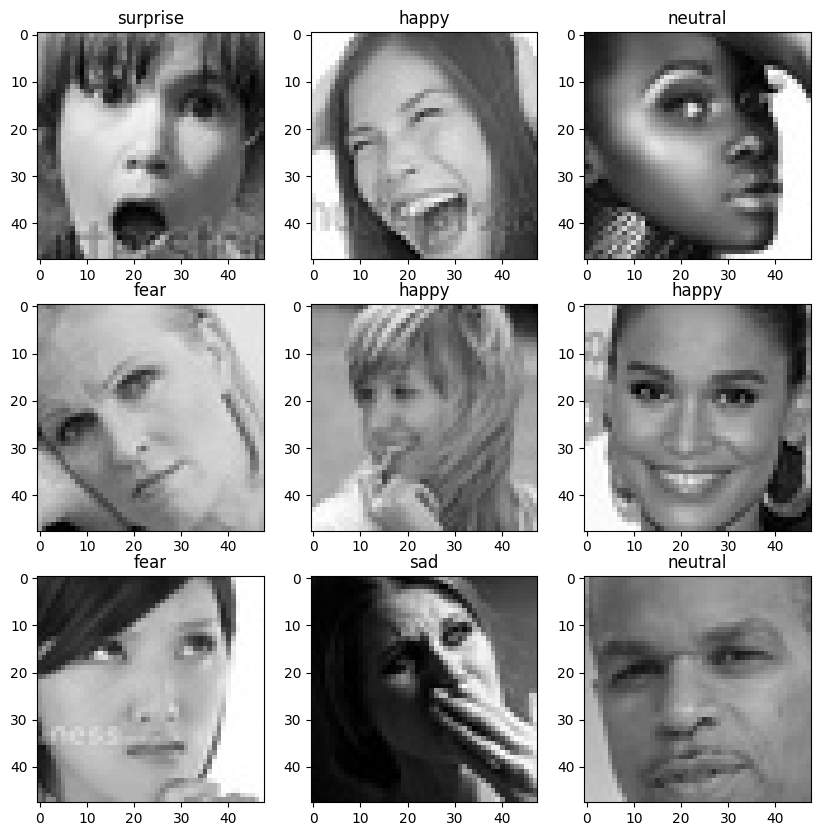

In [4]:
n_rows=3
n_cols=3
plt.figure(figsize=(10,10))
for i in range(n_rows*n_cols):
        index = np.random.randint(0, len(df_train))
        img,label=df_train[index]
        #img = cv2.imread(img)
        class_nm = label
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(img.permute(1,2,0))
        plt.title(df_train.classes[label])
plt.show()

In [5]:
size=4000
train_size=len(df_train)-size

trains_dl,valid_dl=torch.utils.data.random_split(df_train,(train_size,size))
len(trains_dl),len(valid_dl)

(24821, 4000)

In [6]:
from torch.utils.data.dataloader import DataLoader
train_batches=DataLoader(trains_dl,batch_size=64,shuffle=True)
val_batches=DataLoader(valid_dl,batch_size=128,shuffle=True)
len(train_batches),len(val_batches)

(388, 32)

In [7]:
import torch.nn as nn

class cnnModel(nn.Module): 
    def __init__(self):
        nn.Module.__init__(self)
        self.network=nn.Sequential(
        nn.Conv2d(3,16,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1),
        nn.MaxPool2d(2,2),
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
        nn.MaxPool2d(2,2),
        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
        nn.MaxPool2d(2,2),
        
        nn.Flatten(),
        nn.Linear(128*6*6,1024),
        nn.ReLU(),
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.Linear(512,7)
        )
    def model_training(self,data):
        images,labels=data
        out=self(images)
        loss=nn.CrossEntropyLoss()
        return loss(out,labels)
    
    def model_validation(self,data):
        images,labels=data
        out=self(images)
        loss=nn.CrossEntropyLoss()
        return [loss(out,labels).detach(),accuarcy(out,labels)]
    
    def model_validation_epoch(self,output):
        batch_losses=[]
        batch_acc=[]
        for i in output:
            batch_losses.append(i[0].item())
            batch_acc.append(i[1].item())
        epoch_loss=sum(batch_losses)/len(batch_losses)
        batch_loss=sum(batch_acc)/len(batch_acc)
        return [epoch_loss,batch_loss]
    def model_epoch(self,epoch,result):
        print("Epoch [{}],train_loss:{:.4f},val_loss:{:.4f},val_acc:{:.4f}".format(epoch,result[2],result[0],result[1]))
    def forward(self,data):
        return self.network(data)
    

In [8]:
def accuarcy(outputs,labels):
        _,pred=torch.max(outputs,dim=1)
        return torch.tensor(torch.sum(pred==labels).item())/len(pred)

In [9]:
model=cnnModel()
model

cnnModel(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=4608, out_features=1024, bias=True)
    (14): ReLU()
    (15): Linear(in_features=1024, out_features=512, bias=True)
    (16): ReLU()
    (

In [10]:
def evaluate(model,val_loader):
    model.eval()
    outp=[model.model_validation(batch) for batch in val_loader]
    return model.model_validation_epoch(outp)

In [11]:
def fit(epoch,learning_rate,model,train_ld,val_ld,opt_function):
    his=[]
    optimz=opt_function(model.parameters(),learning_rate)
    i=0
    while(i!=epoch):
        model.train()
        losses=[]
        for bt  in train_ld:
            loss=model.model_training(bt)
            losses.append(loss.item())
            loss.backward()
            optimz.step()
            optimz.zero_grad()
        result=evaluate(model,val_ld)
        result.append(sum(losses)/len(losses))
        model.model_epoch(i,result)
        his.append(result)
        i+=1
    return his

In [12]:
a=evaluate(model,val_batches)
print("val_loss:{},val_acc:{}".format(a[0],a[1]))

val_loss:1.9363374263048172,val_acc:0.17236328125


In [13]:
num_epoch=6
opt_function=torch.optim.SGD
learning_rate=0.003
history=fit(num_epoch,learning_rate,model,train_batches,val_batches,opt_function)

Epoch [0],train_loss:1.9181,val_loss:1.9003,val_acc:0.2512
Epoch [1],train_loss:1.8892,val_loss:1.8748,val_acc:0.2563
Epoch [2],train_loss:1.8695,val_loss:1.8572,val_acc:0.2563
Epoch [3],train_loss:1.8553,val_loss:1.8448,val_acc:0.2534
Epoch [4],train_loss:1.8446,val_loss:1.8354,val_acc:0.2527
Epoch [5],train_loss:1.8365,val_loss:1.8229,val_acc:0.2607


In [32]:
valid_data=DataLoader(df_valid,batch_size=32,shuffle=True)
result=evaluate(model,valid_data)
result

[1.8013283661587745, 0.2542203272359943]

In [33]:
print("val_loss:{},val_acc:{}".format(result[0],result[1]))

val_loss:1.8013283661587745,val_acc:0.2542203272359943


In [16]:
history

[[1.900278352200985, 0.251220703125, 1.918100067327932],
 [1.8747502639889717, 0.25634765625, 1.8892290211215461],
 [1.857187308371067, 0.25634765625, 1.8694848940544522],
 [1.8447943776845932, 0.25341796875, 1.8552547496618683],
 [1.8354331739246845, 0.252685546875, 1.844592745771113],
 [1.822874329984188, 0.2607421875, 1.8364811948279745]]

Text(0, 0.5, 'val_acc')

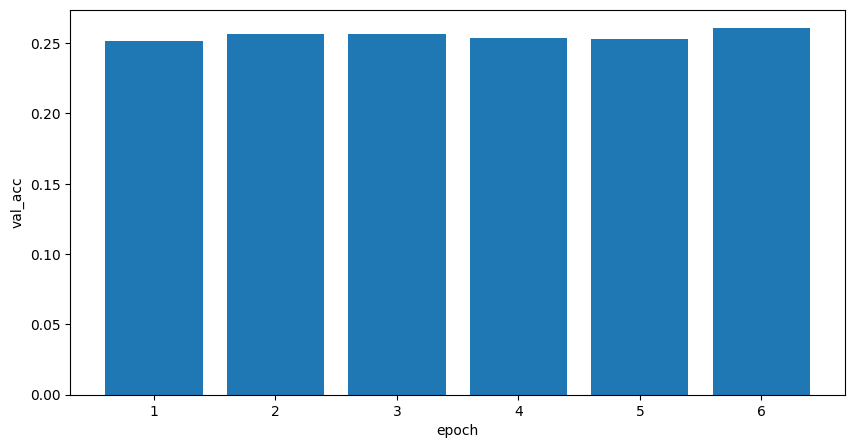

In [17]:
epoch=[i for i in range(1,7)]
acc=[x[1] for x in history]
fig = plt.figure(figsize = (10, 5))
plt.bar(epoch[:],acc[:])
plt.xlabel('epoch')
plt.ylabel('val_acc')

Text(0, 0.5, 'loss')

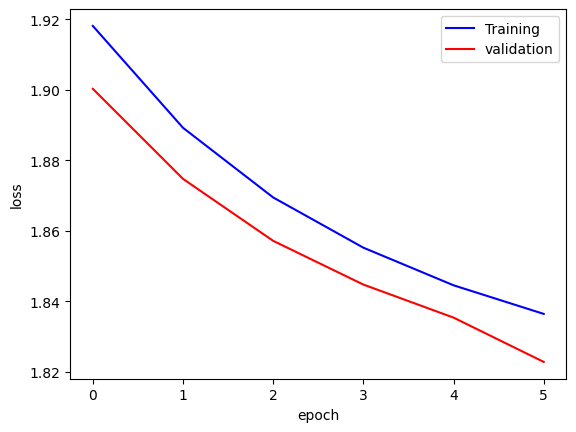

In [18]:
train_loss=[x[2] for x in history]
val=[x[0] for x in history]
plt.plot(train_loss,'-b')
plt.plot(val,'-r')
plt.legend(["Training","validation"])
plt.xlabel('epoch')
plt.ylabel('loss')

In [19]:
class cnnModel1(cnnModel): 
    def __init__(self):
        super().__init__()
        self.network=nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        nn.MaxPool2d(2,2),
        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
        nn.MaxPool2d(2,2),
        nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
        nn.MaxPool2d(2,2),
        
        nn.Flatten(),
        nn.Linear(256*6*6,1024),
        nn.ReLU(),
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.Linear(512,7)
        )

In [20]:
model=cnnModel1()
model

cnnModel1(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=9216, out_features=1024, bias=True)
    (13): ReLU()
    (14): Linear(in_features=1024, out_features=512, bias=True)
    (15): ReLU()
    (16): Linear(

In [21]:
a=evaluate(model,val_batches)
print("val_loss:{},val_acc:{}".format(a[0],a[1]))

val_loss:1.9405790753662586,val_acc:0.251953125


In [22]:
num_epoch=10
opt_function=torch.optim.Adam
learning_rate=0.001
history=fit(num_epoch,learning_rate,model,train_batches,val_batches,opt_function)

Epoch [0],train_loss:1.8454,val_loss:1.8017,val_acc:0.2534
Epoch [1],train_loss:2.4405,val_loss:1.8253,val_acc:0.2539
Epoch [2],train_loss:1.8143,val_loss:1.7980,val_acc:0.2551
Epoch [3],train_loss:1.8049,val_loss:1.7906,val_acc:0.2598
Epoch [4],train_loss:1.7878,val_loss:1.7760,val_acc:0.2737
Epoch [5],train_loss:1.7304,val_loss:1.7021,val_acc:0.3066
Epoch [6],train_loss:1.6856,val_loss:1.6815,val_acc:0.3252
Epoch [7],train_loss:1.6375,val_loss:1.6194,val_acc:0.3647
Epoch [8],train_loss:1.7005,val_loss:1.8015,val_acc:0.2537
Epoch [9],train_loss:1.8007,val_loss:1.8015,val_acc:0.2415


In [40]:
valid_data=DataLoader(df_valid,batch_size=128,shuffle=True)
result=evaluate(model,valid_data)

In [41]:
print("val_loss:{},val_acc:{}".format(result[0],result[1]))

val_loss:1.8017291660819734,val_acc:0.25603107841951506


In [42]:
history

[[1.8017187006771564, 0.25341796875, 1.845390591424765],
 [1.825336031615734, 0.25390625, 2.4405429688925597],
 [1.7979875020682812, 0.255126953125, 1.8142768448775577],
 [1.7905513383448124, 0.259765625, 1.804943179654092],
 [1.7760060466825962, 0.273681640625, 1.7877776134259922],
 [1.7020943760871887, 0.306640625, 1.7303666229715053],
 [1.6814815811812878, 0.3251953125, 1.6855558009491753],
 [1.619397658854723, 0.36474609375, 1.6375403379656606],
 [1.8014682903885841, 0.253662109375, 1.7005142016509145],
 [1.8015021495521069, 0.241455078125, 1.8007008737510013]]

Text(0, 0.5, 'val_acc')

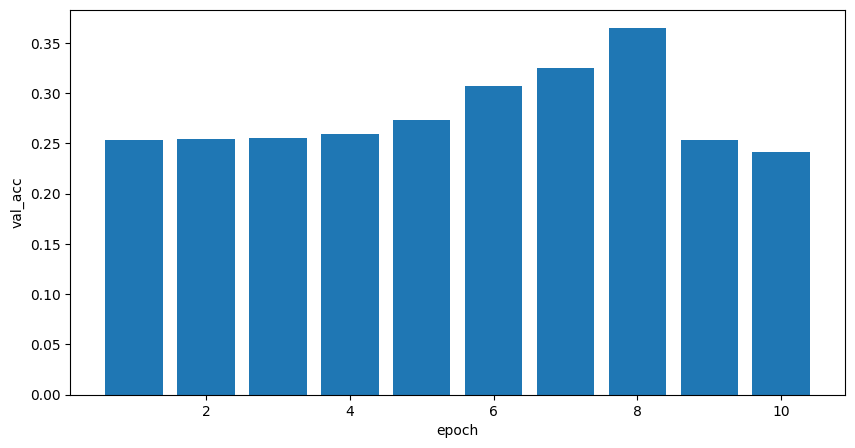

In [44]:
epoch=[i for i in range(1,11)]
acc=[x[1] for x in history]
fig = plt.figure(figsize = (10, 5))
plt.bar(epoch[:],acc[:])
plt.xlabel('epoch')
plt.ylabel('val_acc')

Text(0, 0.5, 'loss')

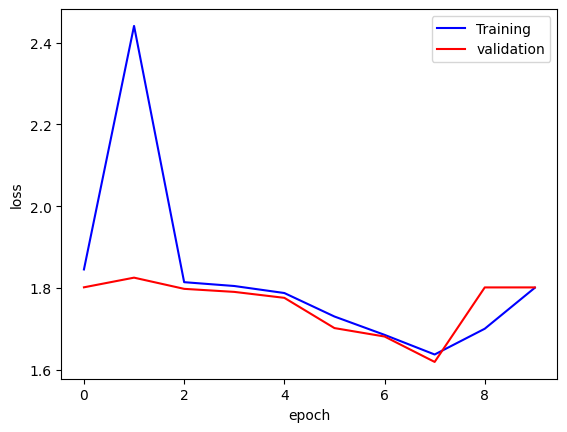

In [45]:
train_loss=[x[2] for x in history]
val=[x[0] for x in history]
plt.plot(train_loss,'-b')
plt.plot(val,'-r')
plt.legend(["Training","validation"])
plt.xlabel('epoch')
plt.ylabel('loss')